In [11]:
import warnings
warnings.filterwarnings('ignore')

In [12]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sompy.sompy import SOMFactory

import matplotlib.pyplot as plt

In [13]:
import warnings
warnings.filterwarnings('ignore')

# **Getting && handling raw data**

In [14]:
df_raw = pd.read_csv('./data/cities_IBGE.csv')

FileNotFoundError: [Errno 2] No such file or directory: './data/cities_IBGE.csv'

In [ ]:
numerical_features = [
    'População estimada [2021]',
    'População no último censo [2010]',
    'Pessoal ocupado [2020]',
    'População ocupada [2020]',
    'Taxa de escolarização de 6 a 14 anos de idade [2010]',
    'Matrículas no ensino fundamental [2021]',
    'Matrículas no ensino médio [2021]',
    'Docentes no ensino fundamental [2021]',
    'Docentes no ensino médio [2021]',
    'Número de estabelecimentos de ensino fundamental [2021]',
    'Número de estabelecimentos de ensino médio [2021]',
    'PIB per capita [2020]',
    'Percentual das receitas oriundas de fontes externas [2015]',
    'Índice de Desenvolvimento Humano Municipal (IDHM) [2010]',
    'Total de receitas realizadas [2017]',
    'Total de despesas empenhadas [2017]',
    'Mortalidade Infantil [2020]',
    'Internações por diarreia [2016]',
    'Estabelecimentos de Saúde SUS [2009]',
    'Área urbanizada [2019]',
    'Esgotamento sanitário adequado [2010]',
    'Arborização de vias públicas [2010]',
    'Urbanização de vias públicas [2010]',
    'População exposta ao risco [2010]',
    'Área da unidade territorial [2021]'
]

In [ ]:
cities = df_raw['Município']
df_raw = df_raw.drop(columns=['Município'])

In [ ]:
df_raw.shape

(185, 38)

In [ ]:
cities

0      Brejo da Madre de Deus
1        Camocim de São Félix
2                      Lajedo
3                    Iguaracy
4                  Tracunhaém
                ...          
180               Belo Jardim
181    Vitória de Santo Antão
182                Santa Cruz
183                   Condado
184    Santa Maria do Cambucá
Name: Município, Length: 185, dtype: object

# **K-Means model**

## **Handling data for k-means:**

### It is common to select only numerical features, since they can be easily normalized and compared on a common scale, enabling distance-based clustering algorithms.

In [ ]:
def normalize_data(df: pd.DataFrame) -> pd.DataFrame:

    for feature in df.columns:
        mean_val = df[feature].mean()
        nan_count = df[feature].isna().sum()

        df[feature].fillna(mean_val, inplace=True)
        df[feature] = df[feature].astype(np.float64)
        df[feature].replace(mean_val, nan_count, inplace=True)

    df = StandardScaler().fit_transform(df)
    
    return df

In [ ]:
df_numerical_features = df_raw[numerical_features]
df = normalize_data(df_numerical_features)

df.shape

(185, 25)

## **Looking for optimal number of components that describes well the cities:**

### The scree plot shows where the proportion of variance explained by each additional principal component begins to level off, indicating the number of principal components to retain.
### The cumulative explained variance plot shows the number of principal components that capture a desired amount of variance in the data. 

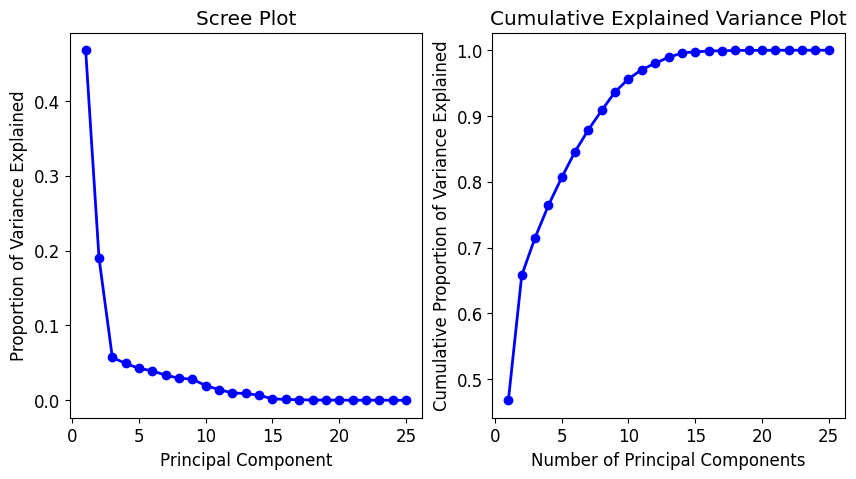

In [ ]:
pca = PCA()

df_pca = pca.fit(df)

fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

axs[0].plot(range(1, df_pca.n_components_+1), df_pca.explained_variance_ratio_, 'bo-', linewidth=2)
axs[0].set_xlabel('Principal Component')
axs[0].set_ylabel('Proportion of Variance Explained')
axs[0].set_title('Scree Plot')

axs[1].plot(range(1, df_pca.n_components_+1), df_pca.explained_variance_ratio_.cumsum(), 'bo-', linewidth=2)
axs[1].set_xlabel('Number of Principal Components')
axs[1].set_ylabel('Cumulative Proportion of Variance Explained')
axs[1].set_title('Cumulative Explained Variance Plot')

plt.show()

In [ ]:
df = PCA(3).fit_transform(df)

## **Looking for optimal K parameter**:

### Inertia is a metric used to evaluate the quality of k-means clustering. It is defined as the sum of the squared distances between each data point and its assigned cluster center. The lower the inertia value, the better the clustering performance.

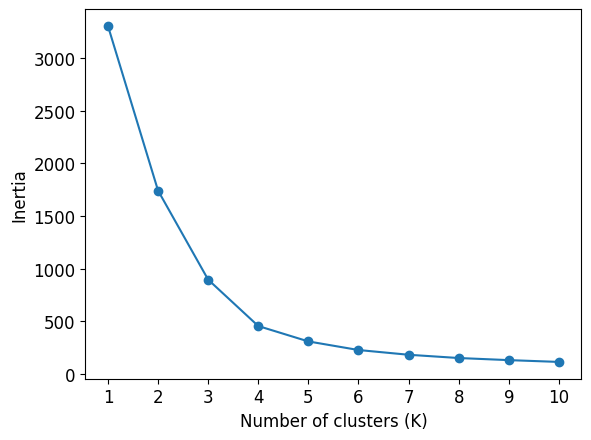

In [ ]:
inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df)
    inertia.append(kmeans.inertia_)
    
plt.plot(k_values, inertia, '-o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.show()

## **Training optimal model**

In [ ]:
optimal_K = 5 # same number of "Mesoregiões" in Pernambuco
optimal_kmeans = KMeans(n_clusters=optimal_K, random_state=42)
labels = optimal_kmeans.fit_predict(df)

In [ ]:
labels = optimal_kmeans.labels_
df_clustered = pd.DataFrame({'Município': cities, 'Cluster': labels})

In [ ]:
city_groups_KMeans = []

for cluster in sorted(set(df_clustered['Cluster'])):
    group = df_clustered[df_clustered['Cluster'] == cluster]['Município'].tolist()
    city_groups_KMeans.append(group)

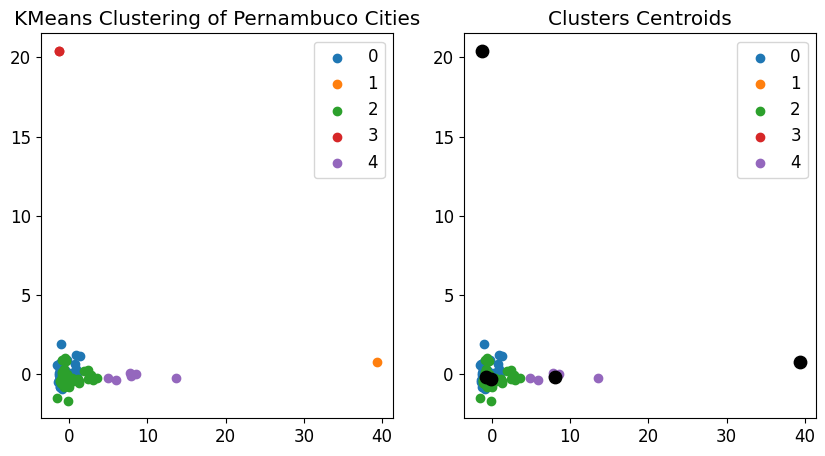

In [ ]:
centroids = optimal_kmeans.cluster_centers_
u_labels = np.unique(labels)


fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

for i in u_labels:
    axs[0].scatter(df[labels == i , 0] , df[labels == i , 1] , label = i)
    axs[1].scatter(df[labels == i , 0] , df[labels == i , 1] , label = i)

# adding centroids on the right plot
axs[1].scatter(centroids[:, 0], centroids[:, 1], s=80, color='k')

axs[0].set_title("KMeans Clustering of Pernambuco Cities")
axs[0].legend()

axs[1].set_title("Clusters Centroids")
axs[1].legend()

plt.show()

## **Model analysis**:

### I believe that this clustering of cities provides a good description of how the economic dynamics operate within these cities based on their mesoregion and microregion.

In [ ]:
city_groups_KMeans[0]

['Brejo da Madre de Deus',
 'Camocim de São Félix',
 'Lajedo',
 'Iguaracy',
 'Trindade',
 'Santa Filomena',
 'Araçoiaba',
 'Araripina',
 'Santa Maria da Boa Vista',
 'São José da Coroa Grande',
 'Angelim',
 'Toritama',
 'Itaíba',
 'Correntes',
 'Passira',
 'Manari',
 'Cedro',
 'Quixaba',
 'Salgadinho',
 'Carnaíba',
 'Itapetim',
 'Ouricuri',
 'São Joaquim do Monte',
 'Cabrobó',
 'Salgueiro',
 'Jupi',
 'Glória do Goitá',
 'Arcoverde',
 'Betânia',
 'Águas Belas',
 'Tamandaré',
 'Mirandiba',
 'São José do Belmonte',
 'Panelas',
 'Pedra',
 'Tabira',
 'Carnaubeira da Penha',
 'Parnamirim',
 'Lagoa Grande',
 'Pesqueira',
 'Riacho das Almas',
 'Tupanatinga',
 'Terra Nova',
 'Flores',
 'Jucati',
 'São José do Egito',
 'Afogados da Ingazeira',
 'Taquaritinga do Norte',
 'Sanharó',
 'Santa Terezinha',
 'Itaquitinga',
 'São João',
 'Calumbi',
 'Cumaru',
 'Bodocó',
 'Granito',
 'Cachoeirinha',
 'Belém de Maria',
 'Iati',
 'Brejinho',
 'Tuparetama',
 'Altinho',
 'Dormentes',
 'Ibimirim',
 'Saloá',
 

In [ ]:
city_groups_KMeans[1]

['Recife']

In [ ]:
city_groups_KMeans[2]

['Tracunhaém',
 'Bonito',
 'Barreiros',
 'Limoeiro',
 'Primavera',
 'Vicência',
 'Paranatama',
 'Vertentes',
 'Orobó',
 'Machados',
 'Tacaimbó',
 'Joaquim Nabuco',
 'Gravatá',
 'Vertente do Lério',
 'Escada',
 'Camutanga',
 'Bezerros',
 'São Lourenço da Mata',
 'Timbaúba',
 'Cortês',
 'Canhotinho',
 'Petrolândia',
 'Brejão',
 'Capoeiras',
 'Amaraji',
 'Igarassu',
 'Chã Grande',
 'Garanhuns',
 'Palmeirina',
 'Goiana',
 'Jaqueira',
 'Palmares',
 'Lagoa do Ouro',
 'Maraial',
 'Surubim',
 'Água Preta',
 'Itapissuma',
 'Nazaré da Mata',
 'Jatobá',
 'Lagoa do Carro',
 'Paudalho',
 'Ipojuca',
 'Poção',
 'Chã de Alegria',
 'Abreu e Lima',
 'Sirinhaém',
 'Buenos Aires',
 'São Bento do Una',
 'Ribeirão',
 'Gameleira',
 'Catende',
 'Fernando de Noronha',
 'Ilha de Itamaracá',
 'Lagoa de Itaenga',
 'Camaragibe',
 'Macaparana',
 'Moreno',
 'Sairé',
 'São Vicente Ferrer',
 'Rio Formoso',
 'Xexéu',
 'Cupira',
 'Feira Nova',
 'João Alfredo',
 'Casinhas',
 'Quipapá',
 'Barra de Guabiraba',
 'Bom Jardim

In [ ]:
city_groups_KMeans[3]

['São Caetano', 'Belém de São Francisco']

In [ ]:
city_groups_KMeans[4]

['Jaboatão dos Guararapes',
 'Caruaru',
 'Paulista',
 'Petrolina',
 'Cabo de Santo Agostinho',
 'Olinda']

# **Self-Organizing Map model**

In [ ]:
lattice_shape = 'hexa'

som = SOMFactory.build(df, [10, 10], initialization='random', lattice=lattice_shape)

In [ ]:
som.train(n_job=1, verbose='info')

 Training...
 random_initialization took: 0.000000 seconds
 Rough training...
 radius_ini: 4.000000 , radius_final: 1.000000, trainlen: 17

 epoch: 1 ---> elapsed time:  0.009000, quantization error: 1.861196

 epoch: 2 ---> elapsed time:  0.006000, quantization error: 0.978576

 epoch: 3 ---> elapsed time:  0.006000, quantization error: 0.924597

 epoch: 4 ---> elapsed time:  0.007000, quantization error: 0.893635

 epoch: 5 ---> elapsed time:  0.006000, quantization error: 0.871549

 epoch: 6 ---> elapsed time:  0.044000, quantization error: 0.831747

 epoch: 7 ---> elapsed time:  0.012000, quantization error: 0.807316

 epoch: 8 ---> elapsed time:  0.009000, quantization error: 0.782898

 epoch: 9 ---> elapsed time:  0.006000, quantization error: 0.755791

 epoch: 10 ---> elapsed time:  0.007000, quantization error: 0.725289

 epoch: 11 ---> elapsed time:  0.007000, quantization error: 0.691301

 epoch: 12 ---> elapsed time:  0.030000, quantization error: 0.652379

 epoch: 13 ---> e

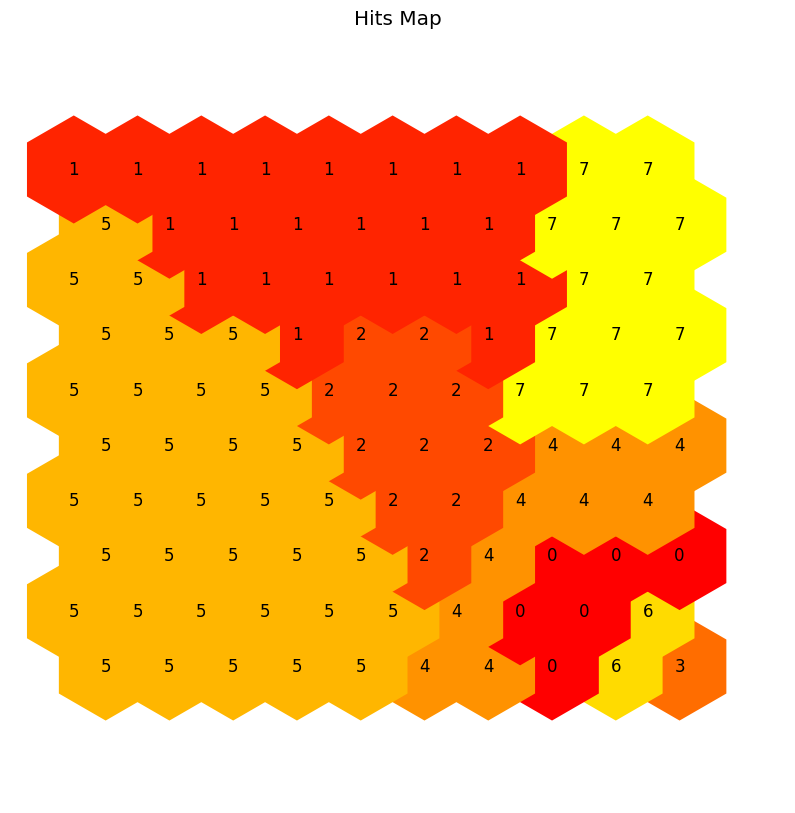

In [ ]:
from sompy.visualization.hitmap import HitMapView

hits_view = HitMapView(10, 10, "Hits Map", text_size=12)
hits_view.show(som, anotate=True, onlyzeros=False, labelsize=12, cmap="autumn")